In [1]:
from scipy import integrate

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pathlib import Path
Path('../fig').mkdir(parents=True, exist_ok=True)

In [2]:
def plot_parameters():
    plt.rcParams["mathtext.fontset"] = "cm"
    plt.rcParams["font.family"] = "STIXGeneral"
    plt.rcParams["figure.figsize"] = [20, 10]  # plot image size
    SMALL_SIZE = 20
    MEDIUM_SIZE = 24
    BIGGER_SIZE = 32

    plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
    plt.rc("axes", titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc("xtick", labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc("ytick", labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc("figure", titlesize=BIGGER_SIZE)

    return SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE


In [3]:
def luminosity_distance(redshift):
    """
    Compute luminosity distance as function of the redshift

    Parameters
    ----------
        redshift: scalar
            Cosmological redshift value

    Returns
    -------
        scalar: Returns luminosity distance relative to given redshift
    """

    # cosmological constants
    # values from https://arxiv.org/pdf/1807.06209.pdf
    h = 0.6796
    H_0 = h * 100 * 1e+3  # Huble constant m s**-1 Mpc**-1
    clight = 2.99792458e8  # speed of lightm s**-1
    Dist_H = clight / H_0  # Huble distance

    Omega_M = 0.315
    Omega_Λ = 1 - Omega_M
    Omega_K = 0.0

    def Ez(z): return 1 / np.sqrt(Omega_M * (1 + z)
                                  ** 3 + Omega_K * (1 + z)**2 + Omega_Λ)
    Dist_C = Dist_H * integrate.quad(Ez, 0, redshift)[0]
    Dist_L = (1 + redshift) * Dist_C

    return Dist_L

In [4]:
def plot_settings(ax, frame, mass_ratio):
    ax.text(15, 40, r"$q = $"+f'{mass_ratio}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e-2, 1e2)
    ax.set_xlim(10, 1e9)
    ax.set_ylabel(r'redshift, $z$')
    ax.set_xlabel(r'final mass $[M_\odot]$'+f'({frame} frame)')

    axx = ax.twinx()
    mn, mx = ax.get_ylim()
    axx.set_yscale("log")
    axx.set_ylim(luminosity_distance(mn) * 1e-3,
                 luminosity_distance(mx) * 1e-3)
    axx.set_ylabel("Luminosity distance [Gpc]")

    
    ## set y ticks    
    x_major = mpl.ticker.LogLocator(base = 10.0, numticks = 20)
    x_minor = mpl.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 20)
    
    ax.xaxis.set_major_locator(x_major)
    ax.xaxis.set_minor_locator(x_minor)
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
    y_major = mpl.ticker.LogLocator(base = 10.0, numticks = 10)
    y_minor = mpl.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)

    ax.yaxis.set_major_locator(y_major)
    ax.yaxis.set_minor_locator(y_minor)
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
    axx.yaxis.set_major_locator(y_major)
    axx.yaxis.set_minor_locator(y_minor)
    axx.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    

In [10]:
# import catalog plot
import sys
sys.path.insert(1, '/Users/iaraota/Dropbox/Doutorado/Doutorado/spectroscopy/catalog')
import plot_catalog

bbh_catalog = plot_catalog.import_bbh_catalog()

In [11]:
def plot_2_modes(data_frame):    
    plot_parameters()
    
    fig, axs = plt.subplots(2, 2)
    
    mass_ratios = [1.5, 10]
    frames = ['source', 'detector']
    detectors = ['LIGO', 'ET', 'CE', 'LISA']
    modes = ['(2,2,1) II', '(3,3,0)', '(4,4,0)', '(2,1,0)']
    two_modes = [('(2,2,0)',mode) for mode in modes]

    colors = {
        '(2,2,1) II': 'tab:red',
        '(3,3,0)': 'tab:green',
        '(4,4,0)': 'tab:blue',
        '(2,1,0)': 'tab:orange',
    }
    linestyles = {
        'LIGO': '-',
        'ET': '--',
        'CE': ':',
        'LISA': '-',
    }
    i = 0 
    for mass_ratio in mass_ratios:
        j = 0 
        for frame in frames:
            plot_catalog.plot_catalog(axs[i,j], bbh_catalog, mass_ratio, 0, frame)
#             catalog_plot(axs[i,j], mass_ratio, frame)
            plot_settings(axs[i,j], frame, mass_ratio)
                    
            for detector in detectors:
                for mode in modes:
                    condition = (data_frame.mode_1 == f'{mode}')&(data_frame.detector == detector)&(data_frame.mass_ratio == mass_ratio)
                    df_plot = data_frame[condition]
                    if frame == 'detector':
                        masses_detector = df_plot.apply(lambda row: row.masses*(1+row.redshifts), axis=1)
                        df_plot = df_plot.assign(masses=masses_detector)
                    if detector == 'LISA':
                        axs[i,j].plot(df_plot.masses, df_plot.redshifts, color = colors[mode], ls = linestyles[detector], lw = 3, label=f'${mode[:7]}$')
                    else:
                        axs[i,j].plot(df_plot.masses, df_plot.redshifts, color = colors[mode], ls = linestyles[detector], lw = 3)


            j += 1
        i += 1
        

    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=10)
    fig.tight_layout(rect=(0,0,1,0.9))

    plt.savefig('../fig/rayleigh_horizons.pdf', format='pdf', bbox_inches='tight', dpi = 400)

In [12]:
# data_frame = pd.read_csv('../data/two_modes_horizons.dat', sep='\t')
data_frame = pd.read_csv('../data/rayleigh_horizons.csv')
data_frame

,masses,redshifts,mode_0,mode_1,detector,mass_ratio,snr_0,snr_1,snr_both
0,1.000000e+01,0.000089,"(2,2,0)","(2,2,1) II",LIGO,1.5,126.949369,56.715564,120.968163
1,1.023372e+01,0.000139,"(2,2,0)","(2,2,1) II",LIGO,1.5,86.068288,38.302551,81.928547
2,1.047290e+01,0.000146,"(2,2,0)","(2,2,1) II",LIGO,1.5,86.803291,38.480846,82.544765
3,1.071767e+01,0.000153,"(2,2,0)","(2,2,1) II",LIGO,1.5,87.535105,38.656499,83.158303
4,1.096816e+01,0.000164,"(2,2,0)","(2,2,1) II",LIGO,1.5,86.224710,37.932518,81.833992
...,...,...,...,...,...,...,...,...,...
9154,5.004939e+08,0.011046,"(2,2,0)","(2,1,0)",LISA,10.0,11077.751562,11307.722051,2314.209176
9155,5.121755e+08,0.010582,"(2,2,0)","(2,1,0)",LISA,10.0,11550.005335,11805.286650,2347.936955
9156,5.241298e+08,0.010137,"(2,2,0)","(2,1,0)",LISA,10.0,12043.213750,12324.701816,2382.255010
9157,5.363631e+08,0.009573,"(2,2,0)","(2,1,0)",LISA,10.0,12740.654115,13053.674032,2452.702872


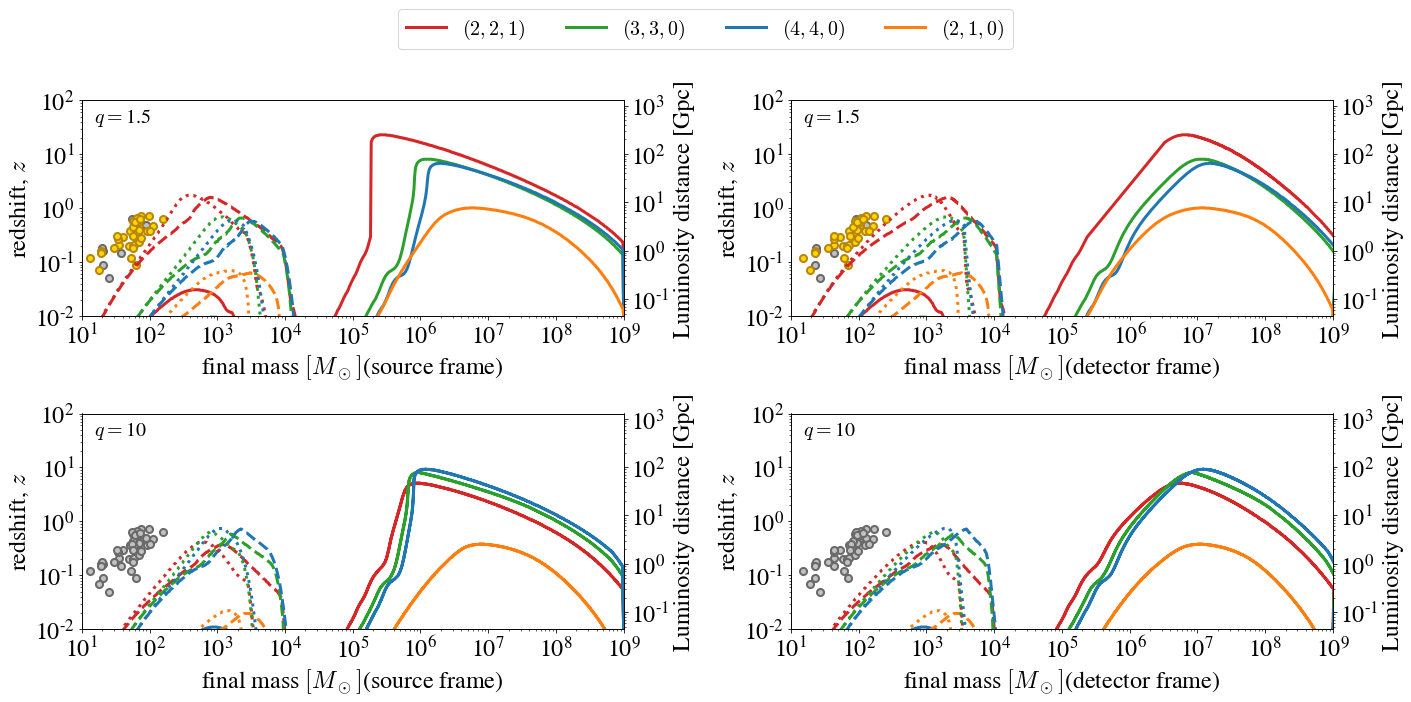

In [13]:
plot_2_modes(data_frame)


In [14]:
def plot_settings_LIGO(ax, frame, mass_ratio):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(bottom = 1e-4)
    ax.set_ylabel(r'redshift, $z$')
#     ax.set_xlabel(r'final mass $[M_\odot]$'+f'({frame} frame)')

    axx = ax.twinx()
    mn, mx = ax.get_ylim()
    axx.set_yscale("log")
    axx.set_ylim(luminosity_distance(mn) * 1e-3,
                 luminosity_distance(mx) * 1e-3)
    axx.set_ylabel(f"$D_L$ [Gpc]")

    
    ## set y ticks    
    x_major = mpl.ticker.LogLocator(base = 10.0, numticks =10)
    x_minor = mpl.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 20)
    
    ax.xaxis.set_major_locator(x_major)
    ax.xaxis.set_minor_locator(x_minor)
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
    y_major = mpl.ticker.LogLocator(base = 10.0, numticks = 5)
    y_minor = mpl.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)

    ax.yaxis.set_major_locator(y_major)
    ax.yaxis.set_minor_locator(y_minor)
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
    axx.yaxis.set_major_locator(y_major)
    axx.yaxis.set_minor_locator(y_minor)
    axx.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    

In [15]:
from scipy.signal import savgol_filter

def plot_LIGO(data_frame):    
    data_frame = data_frame[data_frame.detector == 'LIGO']
    plot_parameters()
    fig, ax = plt.subplots(1,2, sharex = True, sharey = True, figsize = [20,4])
    i = 0
    colors = {
        '(2,2,1) II': 'tab:red',
        '(3,3,0)': 'tab:green',
        '(4,4,0)': 'tab:blue',
        '(2,1,0)': 'tab:orange',
    }
    for mass_ratio in data_frame.mass_ratio.unique():
        df_q = data_frame[data_frame.mass_ratio == mass_ratio]
#         plot_catalog.plot_catalog(ax[i], bbh_catalog, mass_ratio, 0, 'source')
        for mode in data_frame.mode_1.unique():
            df_plot = df_q[df_q.mode_1 == mode]

            ax[i].loglog(df_plot.masses, savgol_filter(df_plot.redshifts,5,1),
                         label = f'$(2,2,0)+{mode[:7]}$', color = colors[mode], lw = 3)

        ymin, ymax = ax[i].get_ylim()
        if mass_ratio == 10.0:
            mass_ratio = round(mass_ratio)
        ax[i].text(10, ymax - (ymax - ymin)/5, r"$q = $"+f'{mass_ratio}', verticalalignment = 'top', fontsize = 25)
#         ax[i].axvline(156.3, color = 'k', ls = ':', lw = 2)
        ax[i].axvspan(156.3+36.8, 156.3-22.4, color = 'k', alpha = 0.05, zorder = -10)
#         ax[i].scatter(63, 0.01, marker = '*', color = 'k', s = 100)
        plot_settings_LIGO(ax[i], 'source', mass_ratio)
        ax[i].set_xlabel(r'final mass $[M_\odot]$ (source frame)')

        i += 1

    handles, labels = ax[0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc="upper center", ncol=10, 
        bbox_to_anchor=(0.5, 1.1,))
    fig.tight_layout(rect=(0,0,1,0.9))
    plt.savefig(f'../fig/rayleigh_horizon_LIGO.pdf', bbox_extra_artists=[lgd], bbox_inches='tight')


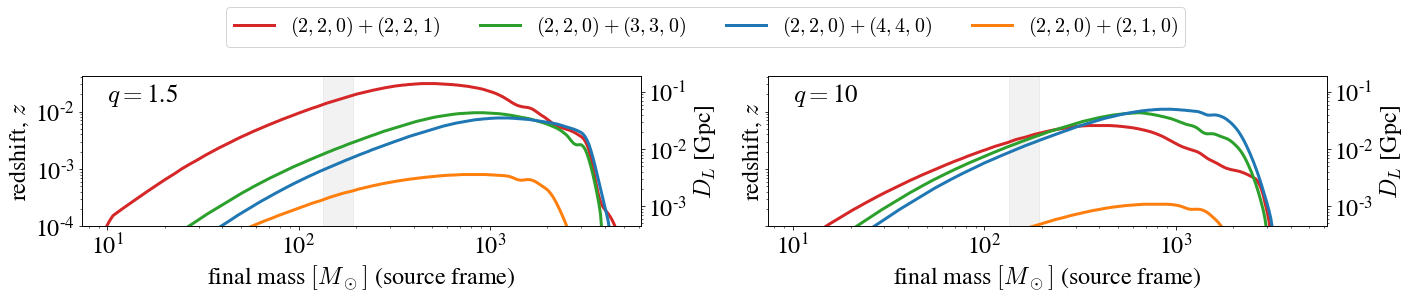

In [16]:
plot_LIGO(data_frame)

In [ ]:
data_frame

In [ ]:
#Plot SNR on Rayleigh horizons
def plot_SNRs(data_frame):    
    
    fig, ax = plt.subplots(6, figsize = [10,30])

    
    mass_ratios = [1.5,10]
    detectors = ['LIGO', 'ET', 'CE', 'LISA']

    colors = {
        '(2,2,1) II': 'tab:red',
        '(3,3,0)': 'tab:green',
        '(4,4,0)': 'tab:blue',
        '(2,1,0)': 'tab:orange',
    }
    linestyles = {
        'LIGO': '-',
        'ET': '--',
        'CE': ':',
        'LISA': '-',
    }
    i = 0 
    frame = 'source'
    for snr in ['snr_0', 'snr_1', 'snr_both']:
        for mass_ratio in mass_ratios:
            for detector in detectors:
                for mode in data_frame.mode_1.unique():
                    condition = (data_frame.mode_1 == f'{mode}')&(data_frame.detector == detector)&(data_frame.mass_ratio == mass_ratio)
                    df_plot = data_frame[condition]
                    ax[i].loglog(df_plot.masses, df_plot[snr].values, color = colors[mode], ls = linestyles[detector], lw = 3)
                    ax[i].set_ylim(10, 1e4)
                    ax[i].set_title(snr)
            i += 1
    fig.tight_layout()
    plt.savefig('../snrs.jpg')    

plot_SNRs(data_frame)


In [ ]:
# Bayes horizons 
bayes_coeffs = {
    1.5: {
        'LIGO': {    
            '(2,2,1) II': [-0.6685, 4.0504 , -6.8045, 1.2680],
            '(3,3,0)': [-0.7298, 4.6084 , -8.3415, 2.3177],
            '(4,4,0)': [-0.5887, 3.8802 , -7.1914, 1.3209],
            '(2,1,0)': [-0.0022, -1.3164,  7.0597, -11.0706],
        },
        'CE': {
            '(2,2,1) II': [-0.2331, 3.3135, -18.5618, 51.7728, -75.6249, 57.1219, -19.7984],
            '(3,3,0)':[-0.2081, 3.1694, -19.3023, 59.5351, -98.0044, 84.0752, -32.0157],
            '(4,4,0)': [-0.1342, 2.1851, -14.4192, 48.7304, -88.7223, 84.6849, -36.0500],
            '(2,1,0)': [-0.1491, 2.3180, -14.5241, 46.3409, -79.3446, 71.1739, -28.7501],
        },
    },
    10: {
        'LIGO':{        
            '(2,2,1) II': [-0.8621, 5.7614, -11.6508 , 4.8845 ],
            '(3,3,0)': [-0.9526, 6.1710,  -12.1380,  5.3732],
            '(4,4,0)': [-1.1328, 7.8589, -16.9297 , 9.4642 ],
        },
        'CE': {
            '(2,2,1) II': [0.1135, -1.5090, 5.8306, -6.9124, -0.07017],
            '(3,3,0)': [0.0647, -1.0693, 4.1535, -3.9086, -1.6608],
            '(4,4,0)': [-0.0107, -0.3054, 1.4965, 0.1276, -4.3371],
            '(2,1,0)': [0.1703, -1.9806, 7.0495, -8.0004, -0.1510],
        }
    },
}

In [ ]:
# find horizon at specific mass
remnant_mass = {
    1.5: 0.955234916738,
    10: 0.991747211983,
}
mode = '(2,2,1) II'
m1 = 100
m2 = {}
M_f = {}
z = {}
for q, mass in remnant_mass.items():
    m2[q] = m1/q
    M_f[q] = (m1+m2[q])*mass
    z[q] = {}
    for detector in bayes_coeffs[q]:
        coeffs =  bayes_coeffs[q][detector][mode]
        horizon = np.poly1d(coeffs)
        z[q][detector] = 10**horizon(np.log10(M_f[q]))

q_chosen = 1.5
for detector in ['LIGO', 'CE']:
    print(detector)
    print('m1: ', m1, ', m2: ', round(m2[q_chosen], 2), ', M_f: ', round(M_f[q_chosen], 2))
    print('z_horizon: ', round(z[q_chosen][detector],4))

#merger rate Gpc^-3 yr^-1 https://arxiv.org/pdf/2010.14533.pdf
merger_rate = {
    'mean': 0.70,
    'upper': 0.65,
    'lower': -0.35,
}
print('merger rate: ',merger_rate['mean']+ merger_rate['lower'], '-',merger_rate['mean']+ merger_rate['upper'], 'Gpc^-3 yr^-1')
# to compute comoving volume from redshift: http://www.astro.ucla.edu/~wright/CosmoCalc.html
# consider flat universe, H_0 = 67.96, Omega_M = 0.315
V_horizon = {#Gpc^3
    'LIGO':{
        45: 0.003,
        100: 0.079, 
    },
    'CE': {
        45: 97.837,
        100:1777.608,
    },
}

rate_horizon = {}
for detector, masses in V_horizon.items():
    rate_horizon[detector] = {}
    print(detector)
    for mass, volume in masses.items():
        rate_horizon[detector][mass] = {
            'lower': (merger_rate['mean']+ merger_rate['lower'])*volume,
            'upper': (merger_rate['mean'] + merger_rate['upper'])*volume,
        }
        print('m1: ', mass, ', rate: ', round(rate_horizon[detector][mass]['lower'], 4), '-', round(rate_horizon[detector][mass]['upper'], 4), '/yr')

In [6]:
#GW190521
# find horizon at specific mass
mode = '(2,2,1) II'
q_chosen = 1.5
m1 = 100
M_f = 156.3
M_i = M_f/remnant_mass[q_chosen]
m1 = M_i/(1 + 1/q_chosen)
m2 = M_i - m1
print('m1: ', round(m1,2), ', m2: ', round(m2, 2), ', M_f: ', round(M_f, 2))

z = {}
for detector in bayes_coeffs[q_chosen]:
    coeffs =  bayes_coeffs[q_chosen][detector][mode]
    horizon = np.poly1d(coeffs)
    z[detector] = 10**horizon(np.log10(M_f))
#     print(detector)
#     print('z_horizon: ', z[detector])

#merger rate Gpc^-3 yr^-1 https://arxiv.org/pdf/2010.14533.pdf
merger_rate = {
    'mean': 0.70,
    'upper': 0.65,
    'lower': -0.35,
}
# to compute comoving volume from redshift: http://www.astro.ucla.edu/~wright/CosmoCalc.html
# consider flat universe, H_0 = 67.96, Omega_M = 0.315
V_horizon = {#Gpc^3
    'LIGO':0.073,
    'CE': 1722.093,
}

rate_horizon = {}
for detector, volume in V_horizon.items():
    rate_horizon = {}
    print(detector)
    rate_horizon[detector] = {
        'lower': (merger_rate['mean']- merger_rate['lower'])*volume,
        'upper': (merger_rate['mean'] + merger_rate['upper'])*volume,
    }
    print('z_horizon: ', round(z[detector],4))
    
    print( 'rate: ', round(rate_horizon[detector]['lower'], 4), '-', round(rate_horizon[detector]['upper'], 4), '/yr')

NameError: name 'remnant_mass' is not defined

peak ratios:


NameError: name 'bayes_coeffs' is not defined

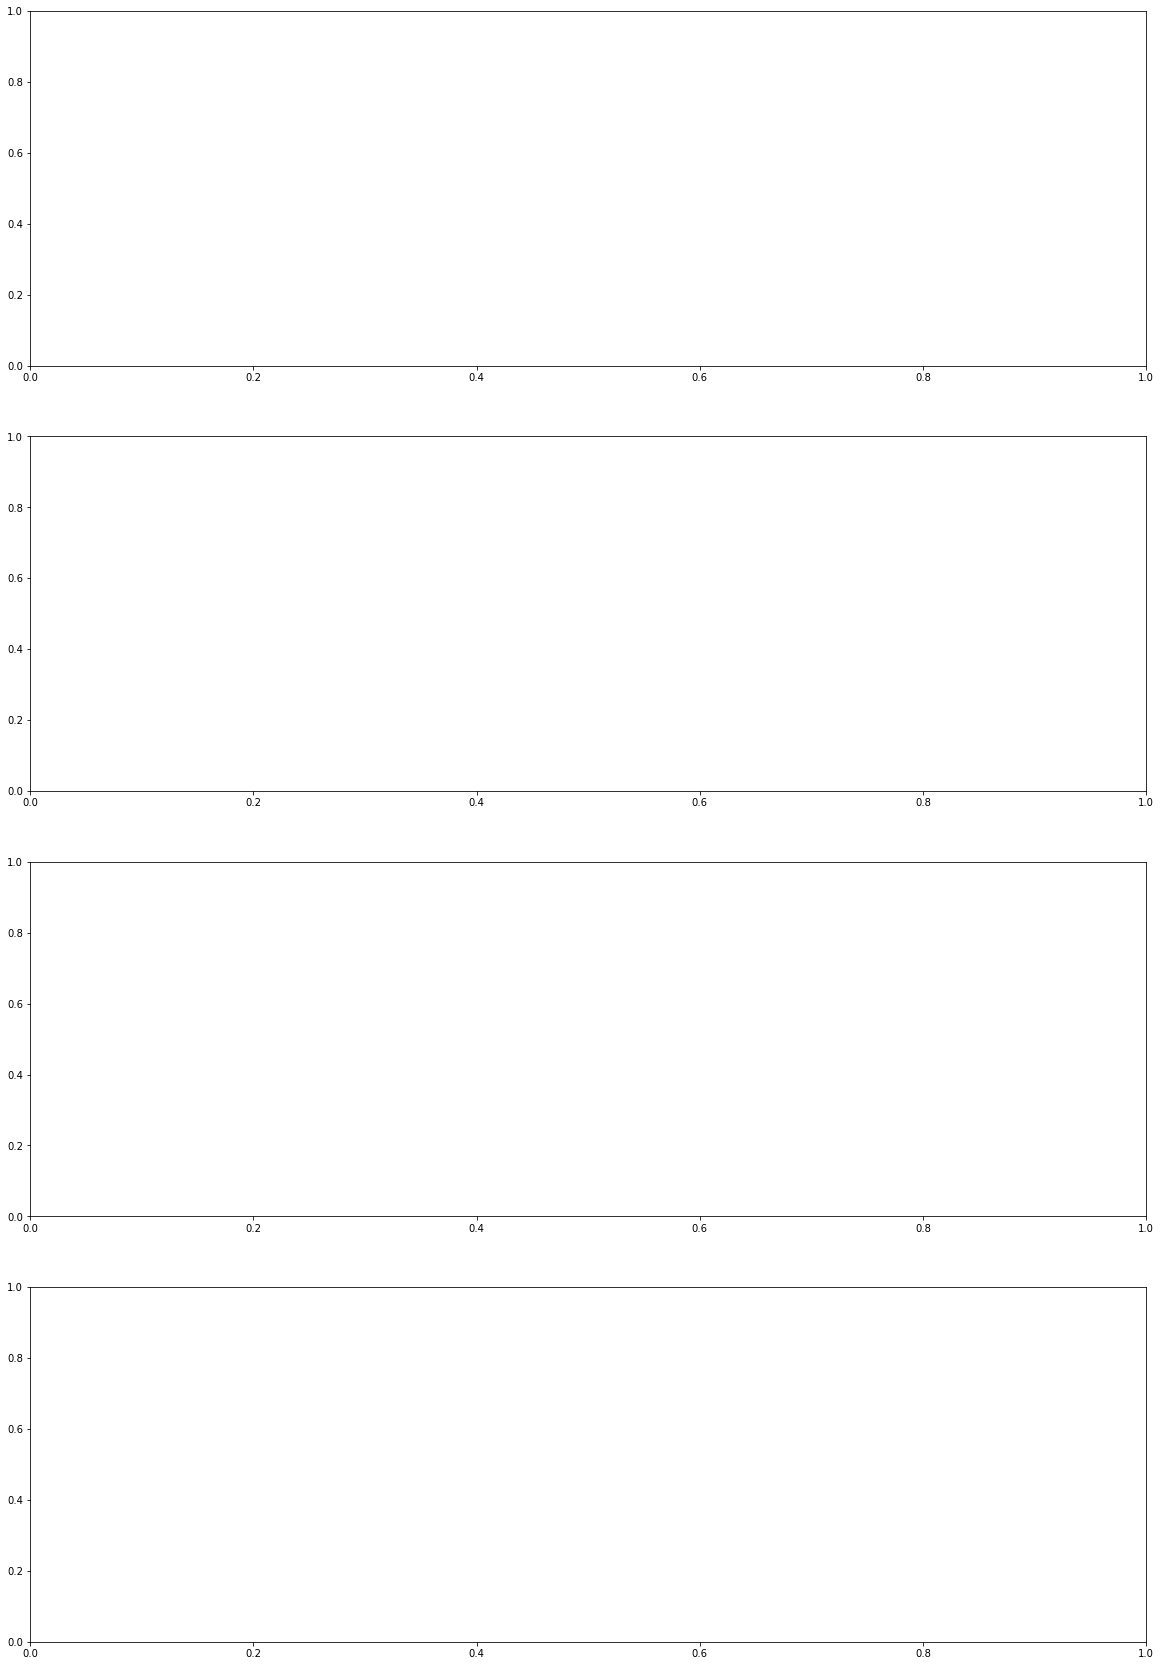

In [7]:
logmasses = np.logspace(1.5, 4, 100)
colors = {
    '(2,2,1) II': 'tab:red',
    '(3,3,0)': 'tab:green',
    '(4,4,0)': 'tab:blue',
    '(2,1,0)': 'tab:orange',
}
print('peak ratios:')
fig, ax = plt.subplots(4, figsize = [20,30])
i = 0
for mass_ratio, detectors in bayes_coeffs.items():
    print('mass ratio: ', mass_ratio)
    for detector, modes in detectors.items():
        print('\t detector: ', detector)
        ax[i].set_title(f'{detector}, q = {mass_ratio}')
        for mode, coeffs in modes.items():
            print('\t\t mode: ', mode)
            horizon = np.poly1d(coeffs)
            ax[i].loglog(logmasses, 10**horizon(np.log10(logmasses)), color = colors[mode], lw = 3)
            df_plot = data_frame[(data_frame.mode_1 == mode)&(
                        data_frame.detector == detector)&(data_frame.mass_ratio==mass_ratio)]
            ax[i].loglog(df_plot.masses, df_plot.redshifts, color = colors[mode], ls = '--', lw = 3)
            ax[i].axhline(max(df_plot.redshifts), ls = '--', c = colors[mode], alpha = 0.5)
            ax[i].axhline(max(10**horizon(np.log10(logmasses))), ls = '--', c = colors[mode], alpha = 0.5)
            print('\t\t\t', max(10**horizon(np.log10(logmasses)))/max(df_plot.redshifts))
        i += 1

In [ ]:
# plot horizons ratio
# plot_parameters()


logmasses = np.logspace(np.log10(10), np.log10(1e4), 100)
colors = {
    '(2,2,1) II': 'tab:red',
    '(3,3,0)': 'tab:green',
    '(4,4,0)': 'tab:blue',
    '(2,1,0)': 'tab:orange',
}
lims = {
    'LIGO': {
        1.5: { 
            '(2,2,1) II': [40, 4e3],
            '(3,3,0)': [65, 4e3],
            '(4,4,0)': [150, 5e3],
            '(2,1,0)': [150, 1.5e3],
        },
        10: { 
            '(2,2,1) II': [2e2, 2.5e3],
            '(3,3,0)': [70, 2.5e3],
            '(4,4,0)': [1e2, 3e3],
    #         '(2,1,0)': [],
        },
    },
    'CE': {
        1.5: { 
            '(2,2,1) II': [10, 1e4],
            '(3,3,0)': [20, 1e4],
            '(4,4,0)': [40, 1e4],
            '(2,1,0)': [23, 7e3],
        },
        10: { 
            '(2,2,1) II': [30, 1e4],
            '(3,3,0)': [20, 7e3],
            '(4,4,0)': [30, 9e3],
            '(2,1,0)': [40, 7e3],
        },
    },
}
fig, ax = plt.subplots(4, figsize = [10,15])
i = 0
ratio_mins = []
for mass_ratio, detectors in bayes_coeffs.items():
    for detector, modes in detectors.items():
        ax[i].set_title(f'{detector}, q = {mass_ratio}')
        for mode, coeffs in modes.items():
            horizon = np.poly1d(coeffs)
            df_plot = data_frame[(data_frame.mode_1 == mode)&(
                        data_frame.detector == detector)&(data_frame.mass_ratio==mass_ratio)&(
                        data_frame.masses >= lims[detector][mass_ratio][mode][0])&(
                        data_frame.masses <= lims[detector][mass_ratio][mode][1])]
            ax[i].loglog(df_plot.masses, 10**horizon(np.log10(df_plot.masses))/df_plot.redshifts, color = colors[mode], lw = 3)
            print(detector, mass_ratio, mode)
            print(min(10**horizon(np.log10(df_plot.masses))/df_plot.redshifts))
            ratio_mins.append(min(10**horizon(np.log10(df_plot.masses))/df_plot.redshifts))
#             ax[i].loglog(df_plot.masses, df_plot.redshifts, color = colors[mode], ls = '--', lw = 3)
        i += 1
fig.tight_layout()
plt.savefig('../horizon_ratios.jpg')
print(min(ratio_mins))

In [8]:
# import catalog plot
import sys
sys.path.insert(1, '../src')
import parameter_dependence_errors as fme


In [ ]:


# antenna_plus = np.sqrt(1 / 5 / 4 / np.pi)
# antenna_cross = antenna_plus
# logmasses = np.logspace(1.5, 4, 50)
# colors = {
#     '(2,2,1) II': 'tab:red',
#     '(3,3,0)': 'tab:green',
#     '(4,4,0)': 'tab:blue',
#     '(2,1,0)': 'tab:orange',
# }

# fig_r, ax_r = plt.subplots(8, figsize = [20,60])
# fig_b, ax_b = plt.subplots(4, figsize = [20,30])
# i = 0
# for mass_ratio, detectors in bayes_coeffs.items():
# #     for detector, modes in detectors.items():
#     for detector in ['LIGO', 'CE', 'ET', 'LISA']:
# #         ax_b[i].set_title(f'Bayes horizon, {detector}, q = {mass_ratio}')
#         ax_r[i].set_title(f'Rayleigh horizon, {detector}, q = {mass_ratio}')
#         for mode in colors:
# #         for mode, coeffs in modes.items():
# #             horizon = np.poly1d(coeffs)
# #             f_b = []
# #             tau_b = []
# #             for mass in logmasses:
# #                 sigma, qnm_pars = fme.compute_errors_single_case(mass, 10**horizon(np.log10(mass)), antenna_plus, antenna_cross, '(2,2,0)', mode, detector, mass_ratio)
# #                 f_b.append(sigma['f_1']/qnm_pars['f_1'])
# #                 tau_b.append(sigma['tau_1']/qnm_pars['tau_1'])
# #             ax_b[i].loglog(logmasses, f_b, color = colors[mode], ls = '-')
# #             ax_b[i].loglog(logmasses, tau_b, color = colors[mode], ls = '--')
            
#             df_plot = data_frame[(data_frame.mode_1 == mode)&(
#                         data_frame.detector == detector)&(data_frame.mass_ratio==mass_ratio)]
# #             ax_b[i].loglog(df_plot.masses, df_plot.redshifts, color = colors[mode], ls = '--', lw = 3)
#             f_r = []
#             tau_r = []
#             masses_r = df_plot.masses[::1]
#             for mass in masses_r:
#                 sigma, qnm_pars = fme.compute_errors_single_case(mass, df_plot['redshifts'][df_plot['masses']==mass].values[0], antenna_plus, antenna_cross, '(2,2,0)', mode, detector, mass_ratio)
#                 f_r.append(sigma['f_1']/qnm_pars['f_1'])
#                 tau_r.append(sigma['tau_1']/qnm_pars['tau_1'])
#             ax_r[i].loglog(masses_r, f_r, color = colors[mode], ls = '-')
#             ax_r[i].loglog(masses_r, tau_r, color = colors[mode], ls = '--')
            
            
#         i += 1